In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time

from sod_model import set_sod_model, optimizer


In [2]:
HEIGHT = 128
WIDTH = 128


def load_trained_model():
    model = set_sod_model()
    opt = optimizer()

    # Locate checkpoints folder (same folder as notebook + project files)
    base = os.getcwd()
    ckpt_dir = os.path.join(base, "checkpoints")

    checkp = tf.train.Checkpoint(model=model, optimizer=opt)
    manager = tf.train.CheckpointManager(checkp, ckpt_dir, max_to_keep=3)

    if manager.latest_checkpoint:
        print(f"Loaded checkpoint: {manager.latest_checkpoint}")
        checkp.restore(manager.latest_checkpoint).expect_partial()
    else:
        print("⚠ No checkpoint found.")

    return model

model = load_trained_model()




Loaded checkpoint: c:\Users\mil\Desktop\CNN Project\CNN Project\checkpoints\ckpt-13


In [3]:
def preprocess_image_array(img_bgr):
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (WIDTH, HEIGHT))
    img = img.astype(np.float32) / 255.0
    return img


In [4]:
def predict(model, img):
    input_tensor = tf.expand_dims(img, axis=0)
    start = time.time()
    pred = model(input_tensor, training=False)
    end = time.time()

    mask = (pred[0].numpy().squeeze() > 0.5).astype(np.float32)

    return mask, end - start


In [5]:
def show_results(img, mask):
    overlay = img.copy()
    overlay[..., 0] = np.maximum(overlay[..., 0], mask)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis("off")

    plt.show()


In [6]:
import ipywidgets as widgets
from IPython.display import display

upload_box = widgets.FileUpload(
    accept='image/*',
    multiple=False
)

display(upload_box)


FileUpload(value=(), accept='image/*', description='Upload')

In [7]:
def process_uploaded_image():
    if not upload_box.value:
        print("Please upload an image first.")
        return

    raw = upload_box.value

    # Handle tuple OR dict formats
    if isinstance(raw, (tuple, list)):
        file_content = raw[0]['content']
    elif isinstance(raw, dict):
        file_content = list(raw.values())[0]['content']
    else:
        print("Unsupported upload format.")
        return

    # Convert bytes → numpy image
    img_bytes = np.frombuffer(file_content, np.uint8)
    img_bgr = cv2.imdecode(img_bytes, cv2.IMREAD_COLOR)

    # Preprocess → predict
    img = preprocess_image_array(img_bgr)
    mask, infer_time = predict(model, img)

    # Display results
    show_results(img, mask)
    print(f"Inference time: {infer_time:.4f} seconds")


Button(button_style='success', description='Run Prediction', style=ButtonStyle())

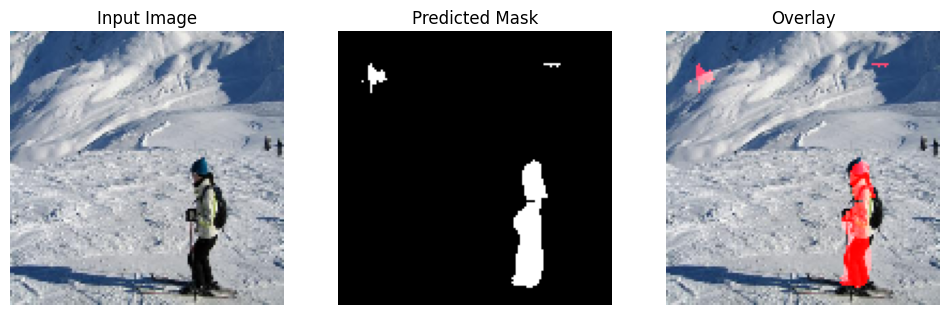

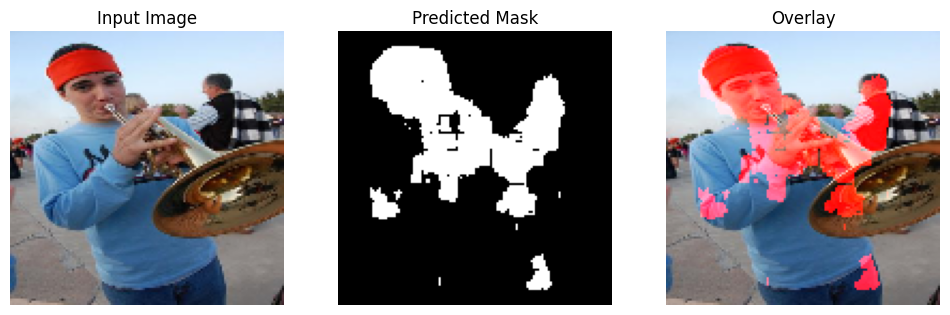

In [8]:
run_btn = widgets.Button(
    description="Run Prediction",
    button_style="success"
)

def on_click_run(b):
    process_uploaded_image()

run_btn.on_click(on_click_run)
display(run_btn)
